In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

def create_eeg_graph(raw, method='correlation', threshold=0.5):
    """
    Создание графа из данных ЭЭГ.

    raw: объект mne.io.Raw
    method: метод оценки связности ('correlation' или 'coherence')
    threshold: порог для рёбер графа
    """
    data = raw.get_data()  # (n_channels, n_samples)
    n_channels = data.shape[0]
    ch_names = raw.info['ch_names']

    # Расчёт матрицы связности
    if method == 'correlation':
        adjacency_matrix = np.corrcoef(data)
    elif method == 'coherence':
        # Для простоты используем абсолютную корреляцию как аналог коэрентности
        adjacency_matrix = np.abs(np.corrcoef(data))
    else:
        raise ValueError("Метод должен быть 'correlation' или 'coherence'.")

    # Применение порога
    adjacency_matrix[adjacency_matrix < threshold] = 0

    # Создание графа
    G = nx.Graph()
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            weight = adjacency_matrix[i, j]
            if weight > 0:
                G.add_edge(ch_names[i], ch_names[j], weight=weight)

    return G, adjacency_matrix

def visualize_eeg_graph(G, raw):
    """
    Визуализация графа ЭЭГ с использованием координат электродов.
    """
    # Получение координат электродов
    ch_names = raw.info['ch_names']
    montage = raw.get_montage()  # Получаем информацию о расположении электродов
    if montage is None:
        raise ValueError("Монтаж отсутствует в данных. Убедитесь, что он установлен.")

    pos = {ch: coord[:2] for ch, coord in montage.get_positions()['ch_pos'].items() if ch in ch_names}

    # Визуализация графа
    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos, with_labels=True, node_size=500, font_size=10,
        node_color='skyblue', edge_color='gray', width=2
    )
    plt.title("Граф функциональной активности мозга")
    plt.show()


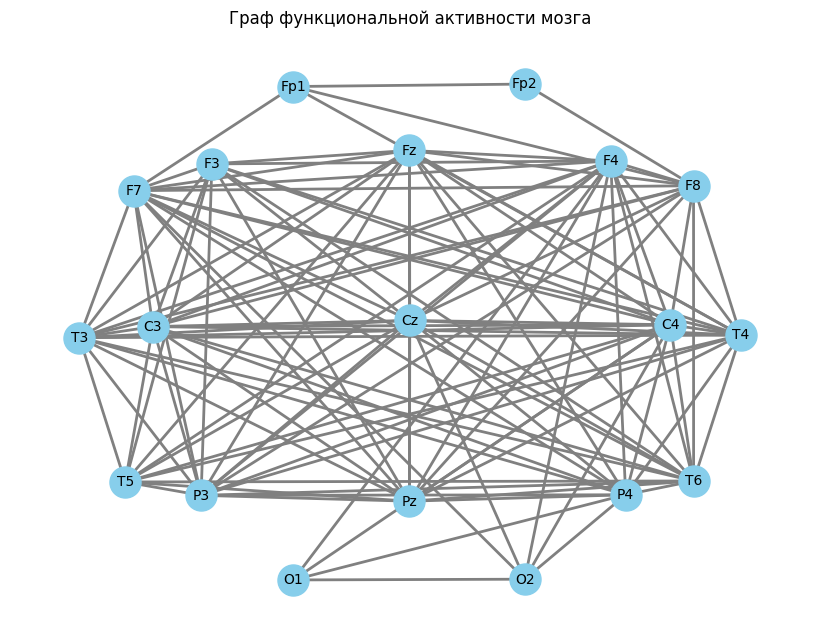

In [5]:
import mne

# Загрузка данных
raw = mne.io.read_raw_eeglab('/Users/taniyashuba/PycharmProjects/eeg-transformer-gnn/data/ds004504/sub-001/eeg/sub-001_task-eyesclosed_eeg.set', preload=True)

# Создание графа
G, adjacency_matrix = create_eeg_graph(raw, method='correlation', threshold=0.5)

# Визуализация графа
visualize_eeg_graph(G, raw)

AttributeError: 'dict' object has no attribute 'ndim'

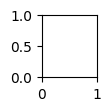

In [4]:
from mne.viz import plot_topomap

# Вычисление средней корреляции для каждого канала
mean_correlation = adjacency_matrix.mean(axis=1)

# Визуализация топографии
info = raw.info  # Информация о каналах
layout = mne.channels.find_layout(info)
ch_pos = {ch: coord[:2] for ch, coord in zip(info['ch_names'], layout.pos)}

plot_topomap(mean_correlation, ch_pos, names=raw.info['ch_names'], show=True)

train dataset: 1680 samples
val dataset: 361 samples
test dataset: 361 samples
Размерность входных данных: torch.Size([32, 5000])
Размерность графа: torch.Size([32, 5000, 5000])
Метка: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


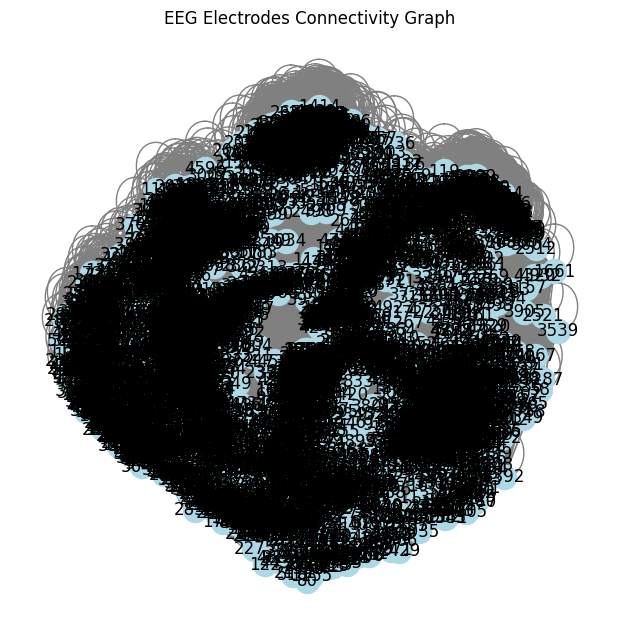

Обработанные датасеты сохранены в: ./data/ds004504/processed


In [22]:
import torch
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# --------------------------------------------------------------------------------
# 1) Настройки
# --------------------------------------------------------------------------------

DATA_DIR = "/Users/taniyashuba/PycharmProjects/eeg-transformer-gnn/data/splits"
OUTPUT_DIR = "./data/ds004504/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Размерность входных данных
NUM_CHANNELS = 19  # Укажите число каналов EEG (например, 19 или 64)
SEQ_LEN = 5000     # Укажите длину последовательности (уменьшение для скорости обработки)

# Гиперпараметры графа
THRESHOLD_CORRELATION = 0.5  # Порог для построения графа на основе корреляции каналов

# --------------------------------------------------------------------------------
# 2) Функция создания графа электродов
# --------------------------------------------------------------------------------

def create_adjacency_matrix(num_channels=NUM_CHANNELS, threshold=THRESHOLD_CORRELATION):
    """
    Создание матрицы смежности на основе взаимосвязи между каналами.
    Можно использовать корреляцию, когерентность или другие меры зависимости.

    Args:
        num_channels (int): Количество каналов EEG.
        threshold (float): Порог корреляции для создания рёбер.

    Returns:
        torch.Tensor: Матрица смежности для GNN.
    """
    np.random.seed(42)
    correlation_matrix = np.random.rand(num_channels, num_channels)

    # Симметризация матрицы
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1)

    # Применение порогового значения для удаления слабых связей
    adjacency_matrix = np.where(correlation_matrix > threshold, 1, 0)

    return torch.tensor(adjacency_matrix, dtype=torch.float32)


# --------------------------------------------------------------------------------
# 3) Класс датасета для обучения модели
# --------------------------------------------------------------------------------

class EEGDataset(Dataset):
    def __init__(self, data_file):
        """
        Загружает и подготавливает данные из сохраненных PyTorch файлов.

        Args:
            data_file (str): Путь к файлу с данными (train_data.pt, val_data.pt, test_data.pt)
        """
        self.X, self.y = torch.load(data_file)

        # Ограничение длины последовательности (уменьшение нагрузки)
        self.X = self.X[:, :SEQ_LEN]

        # Преобразование к float для модели
        self.X = self.X.float()

        # Создание графа для данных
        self.adj_matrix = create_adjacency_matrix(num_channels=self.X.shape[1])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.adj_matrix, self.y[idx]


# --------------------------------------------------------------------------------
# 4) Подготовка DataLoader'ов
# --------------------------------------------------------------------------------

def get_dataloaders(batch_size=32):
    """
    Функция для создания PyTorch DataLoader'ов для train/val/test наборов.

    Args:
        batch_size (int): Размер мини-пакета.

    Returns:
        dict: Словарь с DataLoader'ами для train, val, test.
    """
    train_dataset = EEGDataset(os.path.join(DATA_DIR, "train_data.pt"))
    val_dataset = EEGDataset(os.path.join(DATA_DIR, "val_data.pt"))
    test_dataset = EEGDataset(os.path.join(DATA_DIR, "test_data.pt"))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader
    }


# --------------------------------------------------------------------------------
# 5) Визуализация графа электродов
# --------------------------------------------------------------------------------

def plot_graph(adjacency_matrix):
    """
    Функция для визуализации графа электродов EEG.

    Args:
        adjacency_matrix (torch.Tensor): Матрица смежности.
    """
    if adjacency_matrix.ndim == 3:
        adjacency_matrix = adjacency_matrix[0]  # Берем первую матрицу из батча

    adjacency_matrix = adjacency_matrix.numpy()
    graph = nx.Graph(adjacency_matrix)
    pos = nx.spring_layout(graph)  # Автоматическое расположение узлов

    plt.figure(figsize=(6, 6))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("EEG Electrodes Connectivity Graph")
    plt.show()



# --------------------------------------------------------------------------------
# 6) Запуск обработки
# --------------------------------------------------------------------------------

if __name__ == "__main__":
    dataloaders = get_dataloaders()

    for phase, loader in dataloaders.items():
        print(f"{phase} dataset: {len(loader.dataset)} samples")

    # Проверка одной выборки
    sample_X, sample_adj, sample_y = next(iter(dataloaders['train']))
    print(f"Размерность входных данных: {sample_X.shape}")
    print(f"Размерность графа: {sample_adj.shape}")
    print(f"Метка: {sample_y}")

    # Визуализация графа
    plot_graph(sample_adj)

    # Сохранение датасетов в обработанном виде
    torch.save(dataloaders['train'], os.path.join(OUTPUT_DIR, "train_loader.pt"))
    torch.save(dataloaders['val'], os.path.join(OUTPUT_DIR, "val_loader.pt"))
    torch.save(dataloaders['test'], os.path.join(OUTPUT_DIR, "test_loader.pt"))

    print("Обработанные датасеты сохранены в:", OUTPUT_DIR)
